In [1]:
import geopandas as gpd

In [2]:
import pandas as pd

In [3]:
data = pd.read_excel('data_real/data.xlsx')

/opt/anaconda3/envs/ML/lib/python3.10/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [6]:
data['r_b'] = data['环'].apply(lambda x: 0.9 if x < 5 else (0.8 if x == 5 else 0.7))

In [7]:
data[data['环']==4]

,FID,行,列,环,区,街道,标识符,pop,road,poi,ershoufang,zujin,4,8,11,r_b
604,604,39,19,4,丰台,新村街道,605,7990.099010,4.568266,105,60496.000000,100.866859,84.828181,110.021581,107.750816,0.9
605,605,39,20,4,丰台,花乡地区办事处,606,4192.000000,2.436427,471,27500.000000,97.820356,0.000000,98.166643,97.474068,0.9
606,606,39,21,4,丰台,花乡地区办事处,607,4423.762376,7.324074,193,48006.750000,82.149876,67.749022,95.380196,83.320411,0.9
607,607,39,22,4,丰台,花乡地区办事处,608,4135.353535,13.094410,179,52696.000000,157.155354,0.000000,130.966924,183.343784,0.9
608,608,39,23,4,丰台,花乡地区办事处,609,2583.000000,4.977637,63,51592.000000,127.036702,0.000000,61.526937,192.546467,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1468,1468,22,26,4,朝阳,亚运村街道,1469,11352.040816,8.641826,385,84463.833333,145.329417,126.982672,166.187290,142.818289,0.9
1469,1469,22,27,4,朝阳,亚运村街道,1470,7091.000000,8.540808,184,81470.000000,165.047907,135.248542,220.206008,139.689172,0.9
1470,1470,22,28,4,朝阳,亚运村街道,1471,24004.950495,7.223772,600,77446.473684,136.227679,110.337984,175.212640,123.132412,0.9
1471,1471,22,29,4,朝阳,小关街道,1472,26664.000000,5.329669,824,81880.333333,161.116680,119.744687,229.813866,133.791488,0.9


In [8]:
data_village = gpd.read_file('data_real/六环内城中村/六环内城中村.shp')

In [4]:
data_grid = gpd.read_file('data_real/grid/grid.shp')

In [5]:
data_grid

,行,列,环,区,街道,标识符,pop,road,poi,ershoufang,zujin,4,8,11,geometry
0,54,2,6,房山,阎村镇,1,1914.141414,24.873974,94.0,0.0,0.000000,0.000000,0.000000,0.000000,"POLYGON ((422959.138 4393556.876, 422959.138 4..."
1,54,3,6,房山,阎村镇,2,439.000000,2.024137,8.0,0.0,0.000000,0.000000,0.000000,0.000000,"POLYGON ((423959.138 4393556.876, 423959.138 4..."
2,54,4,6,房山,良乡地区办事处,3,560.000000,2.583739,2.0,0.0,0.000000,0.000000,0.000000,0.000000,"POLYGON ((424959.138 4393556.876, 424959.138 4..."
3,54,5,6,房山,良乡地区办事处,4,1885.000000,2.659241,52.0,0.0,31.250000,0.000000,31.250000,0.000000,"POLYGON ((425959.138 4393556.876, 425959.138 4..."
4,54,6,6,房山,良乡地区办事处,5,1036.633663,1.749587,34.0,10000.0,0.000000,0.000000,0.000000,0.000000,"POLYGON ((426959.138 4393556.876, 426959.138 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2369,1,18,6,昌平,百善镇,2370,440.000000,3.796777,6.0,0.0,0.000000,0.000000,0.000000,0.000000,"POLYGON ((438959.138 4446556.876, 438959.138 4..."
2370,1,19,6,昌平,百善镇,2371,4319.191919,0.721418,7.0,33418.0,0.000000,0.000000,0.000000,0.000000,"POLYGON ((439959.138 4446556.876, 439959.138 4..."
2371,1,20,6,昌平,百善镇,2372,4698.019802,3.347467,59.0,29284.0,71.423934,71.423934,0.000000,0.000000,"POLYGON ((440959.138 4446556.876, 440959.138 4..."
2372,1,21,6,昌平,百善镇,2373,331.683168,4.667819,3.0,0.0,56.967612,0.000000,54.595086,59.340138,"POLYGON ((441959.138 4446556.876, 441959.138 4..."


1459


,geometry
0,"POLYGON ((12973408.791 4848757.915, 12973430.7..."
1,"POLYGON ((12965239.832 4851295.885, 12965274.9..."
2,"POLYGON ((12957516.525 4856968.773, 12957511.1..."
3,"POLYGON ((12957066.472 4847557.453, 12957005.8..."
4,"MULTIPOLYGON (((12968967.344 4840313.774, 1296..."
...,...
939,"POLYGON ((12939653.615 4858756.780, 12939858.2..."
940,"POLYGON ((12945819.822 4865293.534, 12945704.6..."
941,"POLYGON ((12967597.895 4851467.967, 12967598.2..."
942,"POLYGON ((12963156.515 4864347.589, 12963156.9..."


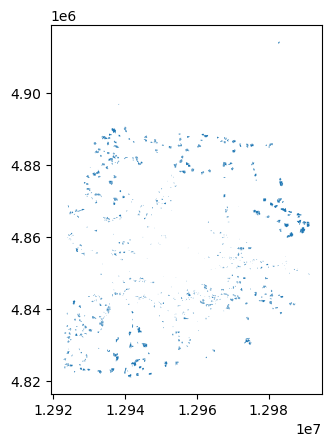

In [9]:
import geopandas as gpd
from shapely.ops import unary_union
import numpy as np

gdf = data_village
gdf = gdf.to_crs(3857)
distance_threshold = 10
distance_matrix = gdf.geometry.apply(lambda geom: gdf.distance(geom)).values
print(len(gdf))

# Find clusters of geometries within the distance threshold
num_geometries = len(gdf)
visited = np.zeros(num_geometries, dtype=bool)
clusters = []

for i in range(num_geometries):
    if visited[i]:
        continue
    cluster = [i]
    visited[i] = True
    for j in range(i + 1, num_geometries):
        if not visited[j] and distance_matrix[i, j] <= distance_threshold:
            cluster.append(j)
            visited[j] = True
    clusters.append(cluster)

# Merge geometries within each cluster
merged_geometries = []
for cluster in clusters:
    geometries_to_merge = gdf.geometry.iloc[cluster]
    merged_geometry = unary_union(geometries_to_merge)
    merged_geometries.append(merged_geometry)

# Create a new GeoDataFrame with merged geometries
merged_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(merged_geometries), crs=gdf.crs)
merged_gdf.plot()
merged_gdf

In [10]:
sum(merged_gdf.geometry.area)

105143644.04142797

<Axes: >

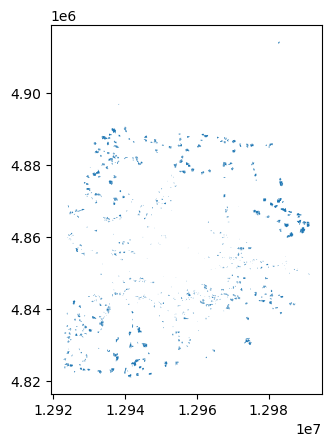

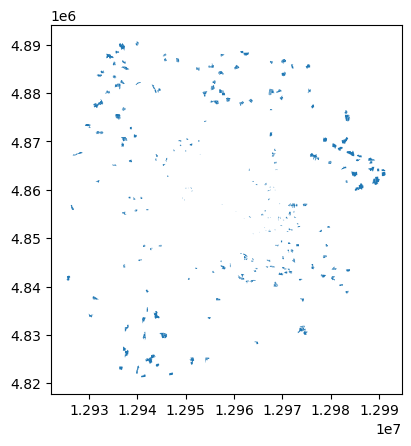

In [59]:
center_point = gpd.points_from_xy([1.296e7], [4.86e6], crs=3857)
center_point = center_point[0]
alpha = 1
beta = 10
num_village = 300

merged_gdf['area'] = merged_gdf.geometry.area

# Compute distance to the center point for each geometry
merged_gdf['distance_to_center'] = merged_gdf.geometry.distance(center_point)

# Compute the weighted score
merged_gdf['score'] = alpha * merged_gdf['area'] - beta * merged_gdf['distance_to_center']

# Sort by the score in ascending order
sorted_gdf = merged_gdf.sort_values(by='score', ascending=True).reset_index(drop=True)

# Drop intermediate columns (optional, for cleaner output)
top_k_gdf = merged_gdf.nlargest(num_village, 'score').reset_index(drop=True)

    # Drop intermediate columns (optional, for cleaner output)
top_k_gdf = top_k_gdf.drop(columns=['area', 'distance_to_center', 'score'])

merged_gdf.plot()

top_k_gdf.plot()

In [11]:
gdf_to_use = merged_gdf

grid_gdf = gpd.read_file('data_real/grid/grid.shp')
if gdf_to_use.crs != grid_gdf.crs:
    grid_gdf = grid_gdf.to_crs(gdf_to_use.crs)

# Assign each geometry in top_k_gdf to the grid with the majority of its area
assignments = []
for index, geom in gdf_to_use.iterrows():
    max_area = 0
    assigned_grid = None
    for grid_idx, grid in grid_gdf.iterrows():
        intersection = geom.geometry.intersection(grid.geometry)
        if intersection.is_empty:
            continue
        intersection_area = intersection.area
        if intersection_area > max_area:
            max_area = intersection_area
            assigned_grid = grid_idx
    assignments.append(assigned_grid)

# Add grid assignments to the top_k_gdf
gdf_to_use['assigned_grid'] = assignments

# Compute the total area of geometries belonging to each grid
gdf_to_use['area'] = gdf_to_use.geometry.area
area_summary = gdf_to_use.groupby('assigned_grid')['area'].sum().reset_index()

# Merge the area summary back with the grid GeoDataFrame
grid_area_summary = grid_gdf.merge(area_summary, left_index=True, right_on='assigned_grid', how='left')
grid_area_summary['area'] = grid_area_summary['area'].fillna(0)  # Fill grids with no assigned geometries

sum(grid_area_summary['area'])

KeyboardInterrupt: 

In [75]:
grid_area_summary.to_file('processed_data1.shp', encoding='utf-8-sig')

/var/folders/yb/w1qwrwh55f300v9spqr_xsrc0000gn/T/ipykernel_92624/3383032499.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  grid_area_summary.to_file('processed_data1.shp', encoding='utf-8-sig')


In [12]:
grid_area_summary = gpd.read_file('processed_data1.shp')

In [13]:
grid_area_summary

,index,行,列,环,区,街道,标识符,pop,road,poi,ershoufang,zujin,4,8,11,assigned_g,area,geometry
0,NaN,54,2,6,房山,阎村镇,1,1914.141414,24.873974,94.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,"POLYGON ((12924363.646 4820760.952, 12924350.6..."
1,NaN,54,3,6,房山,阎村镇,2,439.000000,2.024137,8.0,0.0,0.000000,0.000000,0.000000,0.000000,1.0,0.0,"POLYGON ((12925661.729 4820773.920, 12925648.8..."
2,NaN,54,4,6,房山,良乡地区办事处,3,560.000000,2.583739,2.0,0.0,0.000000,0.000000,0.000000,0.000000,2.0,0.0,"POLYGON ((12926959.818 4820786.718, 12926947.1..."
3,NaN,54,5,6,房山,良乡地区办事处,4,1885.000000,2.659241,52.0,0.0,31.250000,0.000000,31.250000,0.000000,3.0,0.0,"POLYGON ((12928257.913 4820799.347, 12928245.4..."
4,NaN,54,6,6,房山,良乡地区办事处,5,1036.633663,1.749587,34.0,10000.0,0.000000,0.000000,0.000000,0.000000,4.0,0.0,"POLYGON ((12929556.013 4820811.806, 12929543.6..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2369,NaN,1,18,6,昌平,百善镇,2370,440.000000,3.796777,6.0,0.0,0.000000,0.000000,0.000000,0.000000,2369.0,0.0,"POLYGON ((12944581.100 4890263.272, 12944570.5..."
2370,NaN,1,19,6,昌平,百善镇,2371,4319.191919,0.721418,7.0,33418.0,0.000000,0.000000,0.000000,0.000000,2370.0,0.0,"POLYGON ((12945888.316 4890273.776, 12945877.9..."
2371,NaN,1,20,6,昌平,百善镇,2372,4698.019802,3.347467,59.0,29284.0,71.423934,71.423934,0.000000,0.000000,2371.0,0.0,"POLYGON ((12947195.536 4890284.107, 12947185.3..."
2372,NaN,1,21,6,昌平,百善镇,2373,331.683168,4.667819,3.0,0.0,56.967612,0.000000,54.595086,59.340138,2372.0,0.0,"POLYGON ((12948502.761 4890294.265, 12948492.7..."


In [17]:
raw_data_with_geometry = grid_area_summary.drop(columns=['区','街道','标识符','road','assigned_g', '4', '8', '11', 'index'])
raw_data_with_geometry['环'] = raw_data_with_geometry['环'].apply(lambda x: 0.9 if x < 5 else (0.8 if x == 5 else 0.7))
raw_data_with_geometry = raw_data_with_geometry.rename(columns={'行':'row', '列':'column', 'zujin': 'r_r', 'ershoufang': 'r_c', '环': 'r_b'})
raw_data_with_geometry = raw_data_with_geometry.rename(columns={'poi': 'POI', 'area': 'AREA', 'r_c': 'price_c', 'r_r': 'price_r'})
raw_data_with_geometry
raw_data_with_geometry.to_file('raw_data_with_geometry.shp')

In [18]:
raw_data_with_geometry

,row,column,r_b,pop,POI,price_c,price_r,AREA,geometry
0,54,2,0.7,1914.141414,94.0,0.0,0.000000,0.0,"POLYGON ((12924363.646 4820760.952, 12924350.6..."
1,54,3,0.7,439.000000,8.0,0.0,0.000000,0.0,"POLYGON ((12925661.729 4820773.920, 12925648.8..."
2,54,4,0.7,560.000000,2.0,0.0,0.000000,0.0,"POLYGON ((12926959.818 4820786.718, 12926947.1..."
3,54,5,0.7,1885.000000,52.0,0.0,31.250000,0.0,"POLYGON ((12928257.913 4820799.347, 12928245.4..."
4,54,6,0.7,1036.633663,34.0,10000.0,0.000000,0.0,"POLYGON ((12929556.013 4820811.806, 12929543.6..."
...,...,...,...,...,...,...,...,...,...
2369,1,18,0.7,440.000000,6.0,0.0,0.000000,0.0,"POLYGON ((12944581.100 4890263.272, 12944570.5..."
2370,1,19,0.7,4319.191919,7.0,33418.0,0.000000,0.0,"POLYGON ((12945888.316 4890273.776, 12945877.9..."
2371,1,20,0.7,4698.019802,59.0,29284.0,71.423934,0.0,"POLYGON ((12947195.536 4890284.107, 12947185.3..."
2372,1,21,0.7,331.683168,3.0,0.0,56.967612,0.0,"POLYGON ((12948502.761 4890294.265, 12948492.7..."


In [76]:
raw_data = grid_area_summary.drop(columns=['区','街道','标识符','road','geometry','assigned_grid', '4', '8', '11'])
raw_data['环'] = raw_data['环'].apply(lambda x: 0.9 if x < 5 else (0.8 if x == 5 else 0.7))
raw_data = raw_data.rename(columns={'行':'row', '列':'column', 'zujin': 'r_r', 'ershoufang': 'r_c', '环': 'r_b'})

In [77]:
raw_data = raw_data.rename(columns={'poi': 'POI', 'area': 'AREA', 'r_c': 'price_c', 'r_r': 'price_r'})

In [79]:
raw_data

,row,column,r_b,pop,POI,price_c,price_r,AREA
NaN,54,2,0.7,1914.141414,94.0,0.0,0.000000,0.0
NaN,54,3,0.7,439.000000,8.0,0.0,0.000000,0.0
NaN,54,4,0.7,560.000000,2.0,0.0,0.000000,0.0
NaN,54,5,0.7,1885.000000,52.0,0.0,31.250000,0.0
NaN,54,6,0.7,1036.633663,34.0,10000.0,0.000000,0.0
...,...,...,...,...,...,...,...,...
NaN,1,18,0.7,440.000000,6.0,0.0,0.000000,0.0
NaN,1,19,0.7,4319.191919,7.0,33418.0,0.000000,0.0
NaN,1,20,0.7,4698.019802,59.0,29284.0,71.423934,0.0
NaN,1,21,0.7,331.683168,3.0,0.0,56.967612,0.0


In [80]:
sum(raw_data['AREA'])

104738715.07321952

In [81]:
raw_data.to_csv('grid_information.csv',index=False)

In [82]:
import pandas as pd
import scipy
from scipy.ndimage import uniform_filter
raw_data = pd.read_csv('grid_information.csv')

In [83]:
import numpy as np

In [84]:
raw_data

,row,column,r_b,pop,POI,price_c,price_r,AREA
0,54,2,0.7,1914.141414,94.0,0.0,0.000000,0.0
1,54,3,0.7,439.000000,8.0,0.0,0.000000,0.0
2,54,4,0.7,560.000000,2.0,0.0,0.000000,0.0
3,54,5,0.7,1885.000000,52.0,0.0,31.250000,0.0
4,54,6,0.7,1036.633663,34.0,10000.0,0.000000,0.0
...,...,...,...,...,...,...,...,...
2369,1,18,0.7,440.000000,6.0,0.0,0.000000,0.0
2370,1,19,0.7,4319.191919,7.0,33418.0,0.000000,0.0
2371,1,20,0.7,4698.019802,59.0,29284.0,71.423934,0.0
2372,1,21,0.7,331.683168,3.0,0.0,56.967612,0.0


In [85]:
def fill_zeros_with_average(matrix, precision_threshold=1e-6):
    """
    Replaces values close to zero (|value| < precision_threshold) in an n * m matrix
    with the average of their adjacent non-zero 5x5 grid. Continues until no such values remain.

    Args:
    - matrix (np.ndarray): A 2D numpy array of shape (n, m).
    - precision_threshold (float): Threshold below which values are treated as zero.

    Returns:
    - np.ndarray: The modified matrix with no close-to-zero values.
    """
    matrix = matrix.astype(float)  # Ensure the matrix is float for averaging

    while np.any(np.abs(matrix) < precision_threshold):  # Repeat until there are no close-to-zero values
        new_matrix = matrix.copy()

        # Iterate over the entire matrix
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                if abs(matrix[i, j]) < precision_threshold:  # Only update close-to-zero values
                    # Define the 5x5 window bounds
                    row_min = max(0, i - 2)
                    row_max = min(matrix.shape[0], i + 3)
                    col_min = max(0, j - 2)
                    col_max = min(matrix.shape[1], j + 3)

                    # Extract the 5x5 window
                    window = matrix[row_min:row_max, col_min:col_max]

                    # Treat values close to zero as 0 and extract non-zero values
                    non_zero_values = window[np.abs(window) >= precision_threshold]
                    if len(non_zero_values) > 0:
                        new_matrix[i, j] = non_zero_values.mean()

        matrix = new_matrix  # Update the matrix

    return matrix
    
max_row = raw_data['row'].max() + 1
max_col = raw_data['column'].max() + 1

attribute_columns = raw_data.columns
# print(attribute_columns)
attribute_columns = attribute_columns[2:]

# # Initialize the dictionary to store grids for each attribute
env_state = {attr: np.zeros((max_row, max_col), dtype=np.float32) for attr in attribute_columns}

# Populate the grids
for _, row in raw_data.iterrows():
    r, c = row['row'].astype(int), row['column'].astype(int)
    for attr in attribute_columns:
        env_state[attr][r, c] = row[attr]

attribute_columns
for attr in env_state.keys():
    if attr in ['r_b', 'price_c', 'price_r']:
        env_state[attr] = fill_zeros_with_average(env_state[attr])

In [86]:
def dict_to_csv(state_dict):
    """
    Converts a dictionary of grids (n x m arrays) into a CSV file with each grid cell as a row.

    Args:
    - state_dict (dict): Dictionary with keys as attribute names and values as n x m arrays.
    - output_csv_path (str): Path to save the resulting CSV file.

    Returns:
    - pd.DataFrame: DataFrame containing the flattened grid data.
    """
    # Extract grid dimensions from the first attribute
    example_grid = next(iter(state_dict.values()))
    n, m = example_grid.shape

    # Generate row and column indices
    row_indices, col_indices = np.meshgrid(range(n), range(m), indexing="ij")
    row_indices = row_indices.flatten()
    col_indices = col_indices.flatten()

    # Flatten each grid and store it in a dictionary
    flat_data = {"row": row_indices, "column": col_indices}
    for key, grid in state_dict.items():
        flat_data[key] = grid.flatten()

    # Create a DataFrame
    df = pd.DataFrame(flat_data)

    return df

ndf = dict_to_csv(env_state)
ndf.to_csv('updated_grid_info.csv', index=False)

In [60]:
import geopandas as gpd
from shapely.ops import unary_union
import numpy as np

gdf = gpd.read_file('data_real/六环内城中村/六环内城中村.shp')
gdf = gdf.to_crs(3857)
distance_threshold = 10
distance_matrix = gdf.geometry.apply(lambda geom: gdf.distance(geom)).values
print(len(gdf))

# Find clusters of geometries within the distance threshold
num_geometries = len(gdf)
visited = np.zeros(num_geometries, dtype=bool)
clusters = []

for i in range(num_geometries):
    if visited[i]:
        continue
    cluster = [i]
    visited[i] = True
    for j in range(i + 1, num_geometries):
        if not visited[j] and distance_matrix[i, j] <= distance_threshold:
            cluster.append(j)
            visited[j] = True
    clusters.append(cluster)

# Merge geometries within each cluster
merged_geometries = []
for cluster in clusters:
    geometries_to_merge = gdf.geometry.iloc[cluster]
    merged_geometry = unary_union(geometries_to_merge)
    merged_geometries.append(merged_geometry)

# Create a new GeoDataFrame with merged geometries
merged_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(merged_geometries), crs=gdf.crs)
# merged_gdf.plot()
merged_gdf.geometry


1459


0      POLYGON ((12973408.791 4848757.915, 12973430.7...
1      POLYGON ((12965239.832 4851295.885, 12965274.9...
2      POLYGON ((12957516.525 4856968.773, 12957511.1...
3      POLYGON ((12957066.472 4847557.453, 12957005.8...
4      MULTIPOLYGON (((12968967.344 4840313.774, 1296...
                             ...                        
939    POLYGON ((12939653.615 4858756.780, 12939858.2...
940    POLYGON ((12945819.822 4865293.534, 12945704.6...
941    POLYGON ((12967597.895 4851467.967, 12967598.2...
942    POLYGON ((12963156.515 4864347.589, 12963156.9...
943    POLYGON ((12946381.043 4862696.254, 12946375.1...
Name: geometry, Length: 944, dtype: geometry

In [61]:
sum(merged_gdf.geometry.area)


105143644.04142797

In [62]:

gdf_to_use = merged_gdf

grid_gdf = gpd.read_file('data_real/grid/grid.shp')
if gdf_to_use.crs != grid_gdf.crs:
    grid_gdf = grid_gdf.to_crs(gdf_to_use.crs)

# Assign each geometry in top_k_gdf to the grid with the majority of its area
assignments = []
for index, geom in gdf_to_use.iterrows():
    if index % 50 == 0: print(index)
    max_area = 0
    assigned_grid = None
    for _, grid in grid_gdf.iterrows():
        intersection = geom.geometry.intersection(grid.geometry)
        if intersection.is_empty:
            continue
        intersection_area = intersection.area
        if intersection_area > max_area:
            max_area = intersection_area
            assigned_grid = (grid.行, grid.列)
    assignments.append(assigned_grid)

# Add grid assignments to the top_k_gdf
gdf_to_use['assigned_grid'] = assignments

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900


In [63]:
gdf_to_use['assign_row'] = gdf_to_use['assigned_grid'].apply(lambda x: x[0] if x is not None else None)
gdf_to_use['assign_col'] = gdf_to_use['assigned_grid'].apply(lambda x: x[1] if x is not None else None)

In [87]:
gdf_to_use

,geometry,assigned_grid,assign_row,assign_col,area
0,"POLYGON ((12973408.791 4848757.915, 12973430.7...",919.0,33.0,39.0,238053.275361
1,"POLYGON ((12965239.832 4851295.885, 12965274.9...",1010.0,31.0,33.0,5150.767640
2,"POLYGON ((12957516.525 4856968.773, 12957511.1...",1206.0,27.0,27.0,8934.120551
3,"POLYGON ((12957066.472 4847557.453, 12957005.8...",858.0,34.0,27.0,18067.240724
4,"MULTIPOLYGON (((12968967.344 4840313.774, 1296...",572.0,40.0,36.0,182349.972377
...,...,...,...,...,...
939,"POLYGON ((12939653.615 4858756.780, 12939858.2...",1245.0,26.0,14.0,95681.839653
940,"POLYGON ((12945819.822 4865293.534, 12945704.6...",1513.0,21.0,18.0,114741.982536
941,"POLYGON ((12967597.895 4851467.967, 12967598.2...",1012.0,31.0,35.0,76384.123308
942,"POLYGON ((12963156.515 4864347.589, 12963156.9...",1527.0,21.0,32.0,4903.150023


105143644.04142785

In [89]:
gdf_to_use=gdf_to_use.drop(columns=['assigned_grid', 'area'])

In [90]:
gdf_to_use.to_file('urban_villages.shp')

In [27]:
import pandas as pd
something = ('updated_grid_info.csv')

114907781.11950009